In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import scipy
import lightgbm as lgb

In [2]:
SEED=411

In [3]:
gp = pd.read_csv('aggregated_features.csv')

In [4]:
train = pd.read_csv('data/train.csv', parse_dates=['activation_date'])
test = pd.read_csv('data/test.csv', parse_dates=['activation_date'])

train = train.merge(gp, on='user_id', how='left')
test = test.merge(gp, on='user_id', how='left')

agg_cols = list(gp.columns)[1:]

del gp; gc.collect()

train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,activation_date,user_type,image,image_top_1,deal_probability,avg_days_up_user,avg_times_up_user,med_days_up_user,med_times_up_user,n_user_items
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,8.000000,2.000000,8.0,2.0,2.0
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000,NaN,NaN,NaN,NaN,NaN
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177,4.428571,1.142857,3.0,1.0,9.0
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323,16.714286,2.642857,18.0,3.0,32.0
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797,NaN,NaN,NaN,NaN,NaN


In [5]:
train = train.sort_values(['activation_date']).reset_index(drop=True)

In [6]:
train_index, valid_index = train_test_split(np.arange(len(train)), test_size=0.1, random_state=519)

In [7]:
train.loc[train_index, 'activation_date'].dt.weekday.value_counts()

0    207048
6    205318
1    201131
2    196631
3    191293
4    176527
5    175133
Name: activation_date, dtype: int64

In [8]:
train.loc[valid_index, 'activation_date'].dt.weekday.value_counts()

0    23007
6    22614
1    22289
2    21884
3    21422
4    19599
5    19528
Name: activation_date, dtype: int64

In [9]:
test.loc[:, 'activation_date'].dt.weekday.value_counts()

2    81888
1    81114
0    80191
3    77177
4    70366
6    58909
5    58793
Name: activation_date, dtype: int64

One more thing about the approach that I haven't mentioned yet is that we will have quite some NaN values because not every ID in `train` and `test` occurs in `train_active` and `test_active`. Let's check how big that problem is.

In [10]:
train[agg_cols].isnull().any(axis=1).sum() / len(train) * 100

22.407185198586692

In [11]:
test[agg_cols].isnull().any(axis=1).sum() / len(test) * 100

24.354198545348694

In [12]:
train.isnull().sum(), test.isnull().sum()

(item_id                      0
 user_id                      0
 region                       0
 city                         0
 parent_category_name         0
 category_name                0
 param_1                  61576
 param_2                 654542
 param_3                 862565
 title                        0
 description             116276
 price                    85362
 item_seq_number              0
 activation_date              0
 user_type                    0
 image                   112588
 image_top_1             112588
 deal_probability             0
 avg_days_up_user        336875
 avg_times_up_user       336875
 med_days_up_user        336875
 med_times_up_user       336875
 n_user_items            336875
 dtype: int64, item_id                      0
 user_id                      0
 region                       0
 city                         0
 parent_category_name         0
 category_name                0
 param_1                  22910
 param_2                 2

We have missing features for 22.41% of train and 24.35% of test data. That's not perfect but certainly acceptable. Onto some more basic feature engineering with ideas from [a great kernel](https://www.kaggle.com/tunguz/bow-meta-text-and-dense-features-lb-0-2241?scriptVersionId=3603709).

## Merge FM Features

In [13]:
file_prefix = ['cityxcatxusertype', 'imgxcityxcat', 'imgxisqnxusertype']

In [14]:
merge_cols = []

In [15]:
for fp in file_prefix:
    train_merge = pd.read_csv('train_'+fp+'_features.csv')
    for col in train_merge.columns:
        train.loc[:, fp+col] = train_merge[col]
        merge_cols.append(fp+col)
        
    test_merge = pd.read_csv('test_'+fp+'_features.csv')
    for col in test_merge.columns:
        test.loc[:, fp+col] = test_merge[col]
        
    del train_merge, test_merge; gc.collect()
    print(fp, ' processed')

cityxcatxusertype  processed
imgxcityxcat  processed
imgxisqnxusertype  processed


In [16]:
train.head(3)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,imgxisqnxusertypeitem_num,imgxisqnxusertypeimage_top_1_fm_factor_0,imgxisqnxusertypeimage_top_1_fm_factor_1,imgxisqnxusertypeitem_seq_number_fm_factor_0,imgxisqnxusertypeitem_seq_number_fm_factor_1,imgxisqnxusertypeuser_type_fm_factor_0,imgxisqnxusertypeuser_type_fm_factor_1,imgxisqnxusertypeimage_top_1_fm_bias,imgxisqnxusertypeitem_seq_number_fm_bias,imgxisqnxusertypeuser_type_fm_bias
0,3b896605f03c,9457abfa0ebf,Самарская область,Самара,Личные вещи,Детская одежда и обувь,Для мальчиков,Верхняя одежда,86-92 см (1-2 года),Зимний комбенизон,...,2.708050,0.034563,0.016564,0.131896,0.091174,-0.271732,-0.186077,0.004335,-0.050046,-0.014933
1,c81c34d3aac5,0b161da2b144,Иркутская область,Братск,Бытовая электроника,Телефоны,Аксессуары,Чехлы и плёнки,NaN,Чехол для айфона 6s,...,4.867535,0.156250,0.195026,0.170822,0.108869,-0.271732,-0.186077,0.088228,-0.057042,-0.014933
2,a8ab6225dd06,93d527a1ca66,Пермский край,Краснокамск,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Верхняя одежда,44–46 (M),Продам кожанную куртку,...,3.951244,0.091639,0.048682,0.091206,0.036483,-0.271732,-0.186077,-0.037477,-0.039805,-0.014933


## Merge Image Meta Features

In [17]:
def clean_img(img):
    return img.split('.')[0]

img_size = pd.read_pickle('image_size')
img_size.columns = ['image', 'img_size']
img_size['image'] = img_size['image'].apply(clean_img)

img_size.head()

,image,img_size
0,00000a699c7995573766c5403c2428143e7f0c40b311da...,26580
1,000012cc5c75ccd9dccc1e325d22edc9ec16b9926a0194...,33147
2,000037a93d25a1c3f3066b33d667ed3c03d20a7159b32a...,58595
3,00003f4d0f91fa03e947b568ef83e03295ac735f47a082...,20041
4,00005eb46a94b7fbeaaec8f571bf6c09117329de5bf744...,35086


In [18]:
img_info = pd.read_pickle('ImageInfo')
img_info['image'] = img_info['image'].apply(clean_img)
img_info.head()

,b_intensity_mean,b_intensity_median,b_intensity_std,g_intensity_mean,g_intensity_median,g_intensity_std,gray_intensity_mean,gray_intensity_median,gray_intensity_std,height,image,r_intensity_mean,r_intensity_median,r_intensity_std,width
0,114.722772,136.0,59.721508,118.651285,131.0,61.624471,118.535341,130.0,58.719005,360,00000acce78ccf00d3ca0c550cae60fb319d45861444b3...,119.186609,132.0,59.209544,360
1,52.543616,37.0,37.414370,63.569861,38.0,53.705034,58.899403,37.0,46.463522,360,00001d464b8eb4f0f90b13b9194dc214c492cbe0c484fa...,57.769378,37.0,44.828375,360
2,79.764441,74.0,43.560007,88.342585,69.0,54.921351,85.080445,73.0,48.730061,360,00002821738c1efaa7e73310f7a6e34d34ada6c68e0800...,84.435478,74.0,48.718950,360
3,125.639132,140.0,44.797008,119.821291,139.0,50.236745,122.579225,137.0,46.706144,480,00002f9ed7909130971b635ba54d3c5b3b96ba9349af2d...,123.377737,137.0,46.763684,480
4,107.158964,110.0,24.386396,140.352668,130.0,41.767467,132.294196,126.0,34.738292,360,0000384bc4b1aa7c9dca81f2f56f72a9945728d4afdf66...,133.067969,126.0,35.794328,360


In [19]:
train = train.merge(img_size, how='left', on='image')
train = train.merge(img_info, how='left', on='image')
test = test.merge(img_size, how='left', on='image')
test = test.merge(img_info, how='left', on='image')

merge_cols.extend(img_size.columns[img_size.columns != 'image'].tolist())
merge_cols.extend(img_info.columns[img_info.columns != 'image'].tolist())
   
del img_size, img_info; gc.collect()

166

In [20]:
merge_cols

['cityxcatxusertypeitem_num',
 'cityxcatxusertypecity_fm_factor_0',
 'cityxcatxusertypecity_fm_factor_1',
 'cityxcatxusertypecategory_name_fm_factor_0',
 'cityxcatxusertypecategory_name_fm_factor_1',
 'cityxcatxusertypeuser_type_fm_factor_0',
 'cityxcatxusertypeuser_type_fm_factor_1',
 'cityxcatxusertypecity_fm_bias',
 'cityxcatxusertypecategory_name_fm_bias',
 'cityxcatxusertypeuser_type_fm_bias',
 'imgxcityxcatitem_num',
 'imgxcityxcatimage_top_1_fm_factor_0',
 'imgxcityxcatimage_top_1_fm_factor_1',
 'imgxcityxcatcity_fm_factor_0',
 'imgxcityxcatcity_fm_factor_1',
 'imgxcityxcatcategory_name_fm_factor_0',
 'imgxcityxcatcategory_name_fm_factor_1',
 'imgxcityxcatimage_top_1_fm_bias',
 'imgxcityxcatcity_fm_bias',
 'imgxcityxcatcategory_name_fm_bias',
 'imgxisqnxusertypeitem_num',
 'imgxisqnxusertypeimage_top_1_fm_factor_0',
 'imgxisqnxusertypeimage_top_1_fm_factor_1',
 'imgxisqnxusertypeitem_seq_number_fm_factor_0',
 'imgxisqnxusertypeitem_seq_number_fm_factor_1',
 'imgxisqnxusertypeuse

## Merge NIMA Scores

In [21]:
file_prefix = ['nasnet_nima']

for fp in file_prefix:
    train_merge = pd.read_csv('train_'+fp+'_features.csv')
    print(train_merge.shape)
    for col in train_merge.columns:
        if col == 'image':
            continue
        train.loc[:, fp+col] = train_merge[col]
        merge_cols.append(fp+col)
        
    test_merge = pd.read_csv('test_'+fp+'_features.csv')
    for col in test_merge.columns:
        if col == 'image':
            continue
        test.loc[:, fp+col] = test_merge[col]
        
    del train_merge, test_merge; gc.collect()
    print(fp, ' processed')

(1503424, 12)
nasnet_nima  processed


In [22]:
merge_cols

['cityxcatxusertypeitem_num',
 'cityxcatxusertypecity_fm_factor_0',
 'cityxcatxusertypecity_fm_factor_1',
 'cityxcatxusertypecategory_name_fm_factor_0',
 'cityxcatxusertypecategory_name_fm_factor_1',
 'cityxcatxusertypeuser_type_fm_factor_0',
 'cityxcatxusertypeuser_type_fm_factor_1',
 'cityxcatxusertypecity_fm_bias',
 'cityxcatxusertypecategory_name_fm_bias',
 'cityxcatxusertypeuser_type_fm_bias',
 'imgxcityxcatitem_num',
 'imgxcityxcatimage_top_1_fm_factor_0',
 'imgxcityxcatimage_top_1_fm_factor_1',
 'imgxcityxcatcity_fm_factor_0',
 'imgxcityxcatcity_fm_factor_1',
 'imgxcityxcatcategory_name_fm_factor_0',
 'imgxcityxcatcategory_name_fm_factor_1',
 'imgxcityxcatimage_top_1_fm_bias',
 'imgxcityxcatcity_fm_bias',
 'imgxcityxcatcategory_name_fm_bias',
 'imgxisqnxusertypeitem_num',
 'imgxisqnxusertypeimage_top_1_fm_factor_0',
 'imgxisqnxusertypeimage_top_1_fm_factor_1',
 'imgxisqnxusertypeitem_seq_number_fm_factor_0',
 'imgxisqnxusertypeitem_seq_number_fm_factor_1',
 'imgxisqnxusertypeuse

In [23]:
for df in [train, test]:
    df.loc[:, merge_cols] = df[merge_cols].fillna(-1.)

## Merge OOF Text Features

In [24]:
'''
file_prefix = ['text_lgb', 'text_cwb_rg', 'text_rg', 'text_fm']

for fp in file_prefix:
    train_merge = pd.read_csv(fp+'_oof_val_pred.csv')
    print(train_merge.shape)
    for col in train_merge.columns:
        train.loc[:, fp+col] = train_merge[col]
        merge_cols.append(fp+col)
        
    test_merge = pd.read_csv(fp+'_oof_test_pred.csv')
    for col in test_merge.columns:
        test.loc[:, fp+col] = test_merge[col]
        
    del train_merge, test_merge; gc.collect()
    print(fp, ' processed')
'''

"\nfile_prefix = ['text_lgb', 'text_cwb_rg', 'text_rg', 'text_fm']\n\nfor fp in file_prefix:\n    train_merge = pd.read_csv(fp+'_oof_val_pred.csv')\n    print(train_merge.shape)\n    for col in train_merge.columns:\n        train.loc[:, fp+col] = train_merge[col]\n        merge_cols.append(fp+col)\n        \n    test_merge = pd.read_csv(fp+'_oof_test_pred.csv')\n    for col in test_merge.columns:\n        test.loc[:, fp+col] = test_merge[col]\n        \n    del train_merge, test_merge; gc.collect()\n    print(fp, ' processed')\n"

In [25]:
merge_cols

['cityxcatxusertypeitem_num',
 'cityxcatxusertypecity_fm_factor_0',
 'cityxcatxusertypecity_fm_factor_1',
 'cityxcatxusertypecategory_name_fm_factor_0',
 'cityxcatxusertypecategory_name_fm_factor_1',
 'cityxcatxusertypeuser_type_fm_factor_0',
 'cityxcatxusertypeuser_type_fm_factor_1',
 'cityxcatxusertypecity_fm_bias',
 'cityxcatxusertypecategory_name_fm_bias',
 'cityxcatxusertypeuser_type_fm_bias',
 'imgxcityxcatitem_num',
 'imgxcityxcatimage_top_1_fm_factor_0',
 'imgxcityxcatimage_top_1_fm_factor_1',
 'imgxcityxcatcity_fm_factor_0',
 'imgxcityxcatcity_fm_factor_1',
 'imgxcityxcatcategory_name_fm_factor_0',
 'imgxcityxcatcategory_name_fm_factor_1',
 'imgxcityxcatimage_top_1_fm_bias',
 'imgxcityxcatcity_fm_bias',
 'imgxcityxcatcategory_name_fm_bias',
 'imgxisqnxusertypeitem_num',
 'imgxisqnxusertypeimage_top_1_fm_factor_0',
 'imgxisqnxusertypeimage_top_1_fm_factor_1',
 'imgxisqnxusertypeitem_seq_number_fm_factor_0',
 'imgxisqnxusertypeitem_seq_number_fm_factor_1',
 'imgxisqnxusertypeuse

## Common Features

In [26]:
import string

In [27]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])

for df in [train, test]:
    df['description'].fillna('unknowndescription', inplace=True)
    df['title'].fillna('unknowntitle', inplace=True)

    df['day'] = pd.to_datetime(df['activation_date']).dt.day
    df['weekday'] = pd.to_datetime(df['activation_date']).dt.weekday
    
    for col in ['description', 'title']:
        df['num_words_' + col] = df[col].apply(lambda comment: len(comment.split()))
        df['num_unique_words_' + col] = df[col].apply(lambda comment: len(set(w for w in comment.split())))

    df['words_vs_unique_title'] = df['num_unique_words_title'] / df['num_words_title'] * 100
    df['words_vs_unique_description'] = df['num_unique_words_description'] / df['num_words_description'] * 100
    
    df['city'] = df['region'] + '_' + df['city']
    df['num_desc_punct'] = df['description'].apply(lambda x: count(x, set(string.punctuation)))
    
    for col in agg_cols:
        df[col].fillna(-1, inplace=True)
    
    for col in ['price']:
         df[col].fillna(-1, inplace=True) # use -1 to be distinguished from real price close to avg
        
    for col in ['image_top_1']:
         df[col].fillna(-1, inplace=True)
            
    for col in ['param_1', 'param_2', 'param_3']:
         df[col].fillna('unknownparam', inplace=True)

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khyeh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
target = 'deal_probability'
predictors = [
    'num_desc_punct', 
    'words_vs_unique_description', 'num_unique_words_description', 'num_unique_words_title', 'num_words_description', 'num_words_title',
    'avg_times_up_user', 'avg_days_up_user', 'n_user_items', 
    'price', 'item_seq_number'
] + merge_cols

# ''
categorical = [
    'image_top_1', 'param_1', 'param_2', 'param_3', 
    'city', 'region', 'category_name', 'parent_category_name', 'user_type',
    'day', 'weekday'
]

predictors = predictors + categorical

## Extra Feature Engineering

#### concat param 1,2,3 as new cat

In [30]:
for df in [train, test]:
    df['param_join'] = df['param_1'].astype(str) + ' ' + df['param_2'].astype(str) + ' ' + df['param_3'].astype(str)
                                                                                                         
categorical.append('param_join') 
predictors.append('param_join')

#remove original param
'''
for cat in ['param_1', 'param_2', 'param_3']:
    categorical.remove(cat) 
    predictors.remove(cat)
'''

#### categorical with item_seq_number\price encoding

In [31]:
partial = pd.concat([train[categorical+['price', 'item_seq_number']],
                    test[categorical+['price', 'item_seq_number']]]).reset_index(drop=True)

In [32]:
'''
for cat in categorical:
    gp = partial.groupby(cat)
    
    for df in [train, test]:
        df.loc[:, cat+'_price_avg'] = df[cat].map(gp['price'].apply(lambda x: x[x>=0].mean())).fillna(-1.)
        df.loc[:, cat+'_price_med'] = df[cat].map(gp['price'].apply(lambda x: x[x>=0].median())).fillna(-1.)
        df.loc[:, cat+'_price_sum'] = df[cat].map(gp['price'].apply(lambda x: x[x>=0].sum())).fillna(-1.)
        df.loc[:, cat+'_price_std'] = df[cat].map(gp['price'].apply(lambda x: x[x>=0].std())).fillna(-1.)
        df.loc[:, cat+'_price_na_count'] = df[cat].map(gp['price'].apply(lambda x: x[x<0].count())).fillna(-1.)

        df.loc[:, cat+'_item_seq_num_avg'] = df[cat].map(gp['item_seq_number'].mean()).fillna(-1.)
        df.loc[:, cat+'_item_seq_num_med'] = df[cat].map(gp['item_seq_number'].median()).fillna(-1.)
        df.loc[:, cat+'_item_seq_num_sum'] = df[cat].map(gp['item_seq_number'].sum()).fillna(-1.)
        df.loc[:, cat+'_item_seq_num_unique_count'] = \
                                            df[cat].map(gp['item_seq_number'].apply(lambda x: pd.Series(x).nunique())).fillna(-1.)
        df.loc[:, cat+'_item_seq_num_std'] = df[cat].map(gp['item_seq_number'].std()).fillna(-1.)
        
    predictors = predictors + \
        [cat+'_price_avg',
         cat+'_price_med',
         cat+'_price_sum',
         cat+'_price_std',
         cat+'_price_na_count',
         cat+'_item_seq_num_avg',
         cat+'_item_seq_num_med',
         cat+'_item_seq_num_sum',
         cat+'_item_seq_num_unique_count',
         cat+'_item_seq_num_std']
        
    del gp; gc.collect()
    print(cat, ' processed')
'''

"\nfor cat in categorical:\n    gp = partial.groupby(cat)\n    \n    for df in [train, test]:\n        df.loc[:, cat+'_price_avg'] = df[cat].map(gp['price'].apply(lambda x: x[x>=0].mean())).fillna(-1.)\n        df.loc[:, cat+'_price_med'] = df[cat].map(gp['price'].apply(lambda x: x[x>=0].median())).fillna(-1.)\n        df.loc[:, cat+'_price_sum'] = df[cat].map(gp['price'].apply(lambda x: x[x>=0].sum())).fillna(-1.)\n        df.loc[:, cat+'_price_std'] = df[cat].map(gp['price'].apply(lambda x: x[x>=0].std())).fillna(-1.)\n        df.loc[:, cat+'_price_na_count'] = df[cat].map(gp['price'].apply(lambda x: x[x<0].count())).fillna(-1.)\n\n        df.loc[:, cat+'_item_seq_num_avg'] = df[cat].map(gp['item_seq_number'].mean()).fillna(-1.)\n        df.loc[:, cat+'_item_seq_num_med'] = df[cat].map(gp['item_seq_number'].median()).fillna(-1.)\n        df.loc[:, cat+'_item_seq_num_sum'] = df[cat].map(gp['item_seq_number'].sum()).fillna(-1.)\n        df.loc[:, cat+'_item_seq_num_unique_count'] =    

In [33]:
train.isnull().sum()

item_id                                            0
user_id                                            0
region                                             0
city                                               0
parent_category_name                               0
category_name                                      0
param_1                                            0
param_2                                            0
param_3                                            0
title                                              0
description                                        0
price                                              0
item_seq_number                                    0
activation_date                                    0
user_type                                          0
image                                         112588
image_top_1                                        0
deal_probability                                   0
avg_days_up_user                              

#### Binned item seq number and price

In [34]:
sorted_prices = sorted(partial.price.values)

In [35]:
_, bins = pd.qcut(sorted_prices, 80, labels=None, retbins=True, precision=3, duplicates='drop')
partial['price_binned'] = \
    pd.cut(partial.price, bins=bins, labels=np.arange(len(bins)-1), retbins=False)
partial['price_binned'] = partial['price_binned'].astype(int)
partial['price_binned'].value_counts()

 11            155775
 16            124664
-2147483648    115947
 6              90823
 19             83551
 21             79909
 4              65645
 9              59386
 2              57150
 22             52185
 13             51227
 12             49650
 14             49079
 34             46233
 24             44702
 29             42564
 3              38773
 5              37762
 1              33829
 27             33026
 8              32913
 17             32708
 36             30589
 39             27273
 41             27128
 48             26610
 32             26481
 46             26232
 44             25999
 37             25946
 50             25231
 33             25078
 51             25043
 47             24816
 26             24717
 43             24664
 45             24257
 42             23452
 49             22908
 15             22241
 40             21966
 31             21464
 38             20160
 28             17251
 10             17089
 20       

In [36]:
train.loc[:, 'price_binned'] = partial['price_binned'].values[:train.shape[0]]
test.loc[:, 'price_binned'] = partial['price_binned'].values[train.shape[0]:]

In [37]:
categorical.append('price_binned')
predictors.append('price_binned')

In [38]:
sorted_isqn = sorted(partial.item_seq_number.values)

In [39]:
_, bins = pd.qcut(sorted_isqn, 1000, labels=None, retbins=True, precision=3, duplicates='drop')
partial['isqn_binned'] = \
    pd.cut(partial.item_seq_number.values, bins=bins, labels=np.arange(len(bins)-1), retbins=False)
partial['isqn_binned'] = partial['isqn_binned'].astype(int)
partial['isqn_binned'].value_counts()

-2147483648    121849
 0              78774
 1              64432
 2              56266
 3              50246
 4              46185
 5              42736
 6              39954
 7              37731
 8              35782
 9              33588
 10             31778
 11             30254
 12             28714
 13             27518
 14             26303
 15             25162
 16             24217
 17             23179
 18             22258
 19             21569
 20             20714
 21             19909
 22             19290
 23             18702
 24             17987
 25             17439
 26             16957
 27             16352
 28             16126
                ...  
 197             1813
 233             1807
 140             1792
 196             1775
 139             1765
 141             1762
 184             1741
 211             1734
 183             1732
 143             1732
 201             1728
 144             1710
 220             1709
 145             1676
 186      

In [40]:
train.loc[:, 'isqn_binned'] = partial['isqn_binned'].values[:train.shape[0]]
test.loc[:, 'isqn_binned'] = partial['isqn_binned'].values[train.shape[0]:]

In [41]:
categorical.append('isqn_binned')
predictors.append('isqn_binned')

In [42]:
train.isnull().sum()

item_id                                            0
user_id                                            0
region                                             0
city                                               0
parent_category_name                               0
category_name                                      0
param_1                                            0
param_2                                            0
param_3                                            0
title                                              0
description                                        0
price                                              0
item_seq_number                                    0
activation_date                                    0
user_type                                          0
image                                         112588
image_top_1                                        0
deal_probability                                   0
avg_days_up_user                              

In [43]:
del partial; gc.collect()

98

## Text Features

In [44]:
count_vectorizer_title = CountVectorizer(stop_words=stopwords.words('russian'), lowercase=True, min_df=25)

title_counts = count_vectorizer_title.fit_transform(train['title'].append(test['title']))

train_title_counts = title_counts[:len(train)]
test_title_counts = title_counts[len(train):]


count_vectorizer_desc = TfidfVectorizer(stop_words=stopwords.words('russian'), 
                                        lowercase=True, ngram_range=(1, 2),
                                        max_features=15000)

desc_counts = count_vectorizer_desc.fit_transform(train['description'].append(test['description']))

train_desc_counts = desc_counts[:len(train)]
test_desc_counts = desc_counts[len(train):]

train_title_counts.shape, train_desc_counts.shape

((1503424, 16447), (1503424, 15000))

In [45]:
del title_counts, desc_counts; gc.collect()

0

## Encode Categorical Features

In [46]:
for feature in categorical:
    print(f'Transforming {feature}...')
    encoder = LabelEncoder()
    encoder.fit(train[feature].append(test[feature]).astype(str))
    
    train[feature] = encoder.transform(train[feature].astype(str))
    test[feature] = encoder.transform(test[feature].astype(str))

Transforming image_top_1...
Transforming city...
Transforming region...
Transforming category_name...
Transforming parent_category_name...
Transforming user_type...
Transforming day...
Transforming weekday...
Transforming param_join...
Transforming price_binned...
Transforming isqn_binned...


## Mean Encoding

In [47]:
partial = pd.concat([train[categorical+['price', 'item_seq_number']],
                    test[categorical+['price', 'item_seq_number']]]).reset_index(drop=True)

In [48]:
for feature in categorical:
    gp = train.groupby(feature)[feature].count()
    train.loc[:, feature+'_cnt'] = train[feature].map(gp)
    test.loc[:, feature+'_cnt'] = test[feature].map(gp)
    predictors.append(feature+'_cnt')
    
    del gp; gc.collect()

In [49]:
from sklearn.model_selection import KFold
fold_num = 5
kf = KFold(fold_num, shuffle=True, random_state=SEED)

mean_enc_cols = categorical

for col in mean_enc_cols:    
    
    train.loc[:, col+'_dp_mean_enc'] = np.zeros((train.shape[0],))
    train.loc[:, col+'_dp_std_enc'] = np.zeros((train.shape[0],))
    test.loc[:, col+'_dp_mean_enc'] = np.zeros((test.shape[0],))
    test.loc[:, col+'_dp_std_enc'] = np.zeros((test.shape[0],))
    
    for train_ix, val_ix in kf.split(train):
        tr_X = train.loc[train_ix, :]
    
        gp = tr_X.groupby(col)['deal_probability']
        mapping, mapping_std = gp.mean(), gp.std()
        
        train.loc[val_ix, col+'_dp_mean_enc'] = train.loc[val_ix, col].map(mapping).fillna(-1.)
        train.loc[val_ix, col+'_dp_std_enc'] = train.loc[val_ix, col].map(mapping_std).fillna(-1.)
        
        test.loc[:, col+'_dp_mean_enc'] += test.loc[:, col].map(mapping).fillna(-1.)
        test.loc[:, col+'_dp_std_enc'] += test.loc[:, col].map(mapping_std).fillna(-1.)
     
        del gp; gc.collect()
        
    test.loc[:, col+'_dp_mean_enc'] /= fold_num
    test.loc[:, col+'_dp_std_enc'] /= fold_num
    print(col + ' processed.')
    predictors.extend([col+'_dp_mean_enc', col+'_dp_std_enc'])

image_top_1 processed.
city processed.
region processed.
category_name processed.
parent_category_name processed.
user_type processed.
day processed.
weekday processed.
param_join processed.
price_binned processed.
isqn_binned processed.


(['num_desc_punct',
  'words_vs_unique_description',
  'num_unique_words_description',
  'num_unique_words_title',
  'num_words_description',
  'num_words_title',
  'avg_times_up_user',
  'avg_days_up_user',
  'n_user_items',
  'price',
  'item_seq_number',
  'cityxcatxusertypeitem_num',
  'cityxcatxusertypecity_fm_factor_0',
  'cityxcatxusertypecity_fm_factor_1',
  'cityxcatxusertypecategory_name_fm_factor_0',
  'cityxcatxusertypecategory_name_fm_factor_1',
  'cityxcatxusertypeuser_type_fm_factor_0',
  'cityxcatxusertypeuser_type_fm_factor_1',
  'cityxcatxusertypecity_fm_bias',
  'cityxcatxusertypecategory_name_fm_bias',
  'cityxcatxusertypeuser_type_fm_bias',
  'imgxcityxcatitem_num',
  'imgxcityxcatimage_top_1_fm_factor_0',
  'imgxcityxcatimage_top_1_fm_factor_1',
  'imgxcityxcatcity_fm_factor_0',
  'imgxcityxcatcity_fm_factor_1',
  'imgxcityxcatcategory_name_fm_factor_0',
  'imgxcityxcatcategory_name_fm_factor_1',
  'imgxcityxcatimage_top_1_fm_bias',
  'imgxcityxcatcity_fm_bias',
 

In [60]:
# remove all categorical variables
predictors = [f for f in predictors if f not in mean_enc_cols]
categorical = []

In [50]:
train.isnull().sum(), '\n', test.isnull().sum()

(item_id                                            0
 user_id                                            0
 region                                             0
 city                                               0
 parent_category_name                               0
 category_name                                      0
 param_1                                            0
 param_2                                            0
 param_3                                            0
 title                                              0
 description                                        0
 price                                              0
 item_seq_number                                    0
 activation_date                                    0
 user_type                                          0
 image                                         112588
 image_top_1                                        0
 deal_probability                                   0
 avg_days_up_user           

In [51]:
#train.drop(['image_top_1'], axis=1, inplace=True)
#test.drop(['image_top_1'], axis=1, inplace=True)

In [52]:
del partial; gc.collect()

0

In [53]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [54]:
train.drop(['activation_date', 'item_id', 'user_id', 'title', 'description'], axis=1, inplace=True)
test.drop(['activation_date', 'item_id', 'user_id', 'title', 'description'], axis=1, inplace=True)

In [55]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 1416.43 MB
Memory usage after optimization is: 473.50 MB
Decreased by 66.6%
Memory usage of dataframe is 461.61 MB
Memory usage after optimization is: 150.18 MB
Decreased by 67.5%


In [63]:
predictors, categorical, len(predictors)

(['num_desc_punct',
  'words_vs_unique_description',
  'num_unique_words_description',
  'num_unique_words_title',
  'num_words_description',
  'num_words_title',
  'avg_times_up_user',
  'avg_days_up_user',
  'n_user_items',
  'price',
  'item_seq_number',
  'cityxcatxusertypeitem_num',
  'cityxcatxusertypecity_fm_factor_0',
  'cityxcatxusertypecity_fm_factor_1',
  'cityxcatxusertypecategory_name_fm_factor_0',
  'cityxcatxusertypecategory_name_fm_factor_1',
  'cityxcatxusertypeuser_type_fm_factor_0',
  'cityxcatxusertypeuser_type_fm_factor_1',
  'cityxcatxusertypecity_fm_bias',
  'cityxcatxusertypecategory_name_fm_bias',
  'cityxcatxusertypeuser_type_fm_bias',
  'imgxcityxcatitem_num',
  'imgxcityxcatimage_top_1_fm_factor_0',
  'imgxcityxcatimage_top_1_fm_factor_1',
  'imgxcityxcatcity_fm_factor_0',
  'imgxcityxcatcity_fm_factor_1',
  'imgxcityxcatcategory_name_fm_factor_0',
  'imgxcityxcatcategory_name_fm_factor_1',
  'imgxcityxcatimage_top_1_fm_bias',
  'imgxcityxcatcity_fm_bias',
 

## Pickle them

In [62]:
import pickle
pickle.dump(train, open('train_features_tuning', 'wb'))
pickle.dump(test, open('test_features_tuning', 'wb'))
pickle.dump(train_title_counts, open('train_title_features_tuning', 'wb'))
pickle.dump(test_title_counts, open('test_title_features_tuning', 'wb'))
pickle.dump(train_desc_counts, open('train_desc_features_tuning', 'wb'))
pickle.dump(test_desc_counts, open('test_desc_features_tuning', 'wb'))
pickle.dump(count_vectorizer_title, open('cv_title_features_tuning', 'wb'))
pickle.dump(count_vectorizer_desc, open('cv_desc_features_tuning', 'wb'))
pickle.dump(predictors, open('predictors_features_tuning', 'wb'))
pickle.dump(categorical, open('catgorical_features_tuning', 'wb'))

## Unpickle them

In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import scipy
import lightgbm as lgb

import pickle
train = pickle.load(open('train_features_tuning', 'rb'))
test = pickle.load(open('test_features_tuning', 'rb'))
train_title_counts = pickle.load(open('train_title_features_tuning', 'rb'))
test_title_counts = pickle.load(open('test_title_features_tuning', 'rb'))
train_desc_counts = pickle.load(open('train_desc_features_tuning', 'rb'))
test_desc_counts = pickle.load(open('test_desc_features_tuning', 'rb'))
count_vectorizer_title = pickle.load(open('cv_title_features_tuning', 'rb'))
count_vectorizer_desc = pickle.load(open('cv_desc_features_tuning', 'rb'))
predictors = pickle.load(open('predictors_features_tuning', 'rb'))
categorical = pickle.load(open('catgorical_features_tuning', 'rb'))


target = 'deal_probability'
y_train = pd.read_csv('data/train.csv', usecols=['activation_date', 'deal_probability'], parse_dates=['activation_date']) \
            .sort_values('activation_date') \
            .reset_index(drop=True).deal_probability.values

## Modeling

After some hyperparameter definitions and creating train / valid / test matrices, we can finally train the model. Let's see if the aggregated features helped.

*Note: For further feature engineering, I would recommend restricting the max_depth further (5 worked well for me) and increasing the learning rate (to ~ 0.1) so you don't have to wait forever for the training to finish.*

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm
SEED=411 
kf = KFold(5, shuffle=True, random_state=SEED)
%matplotlib inline

#### Feature Selection: Use only dense features to train!

In [3]:
def feature_select(rounds):
    for i in range(rounds):
        rounds = 2000
        early_stop_rounds = 100
        trial_seed = 0

        feature_importances = None
        for train_ix, val_ix in kf.split(train):
            trial_seed += 1
            params = {
                'objective' : 'regression',
                'metric' : 'rmse',
                'num_leaves' : 31,
                'max_depth': 5,
                'learning_rate' : 0.1,
                'bagging_fraction': .8,
                'bagging_freq': 1,    
                'feature_fraction' : .8,
                'feature_fraction_seed': trial_seed,
                'reg_lambda': 0.0, # force to select other features more
                'verbosity' : -1
            }

            dtrain = lgb.Dataset(train.loc[train_ix, predictors].values, label=y_train[train_ix],
                                 feature_name=list(predictors), 
                                 categorical_feature=categorical)
            dvalid = lgb.Dataset(train.loc[val_ix, predictors].values, label=y_train[val_ix],
                                 feature_name=list(predictors), 
                                 categorical_feature=categorical)

            model = lgb.train(params, dtrain, 
                              valid_sets=[dtrain, dvalid], 
                              valid_names=['train', 'valid'],
                              num_boost_round=rounds, 
                              early_stopping_rounds=early_stop_rounds, 
                              verbose_eval=100)

            current_feat_imp = model.feature_importance(importance_type='gain')
            pd.Series(current_feat_imp).hist()
            plt.show()

            if feature_importances is None:
                feature_importances = current_feat_imp
            else:
                feature_importances += current_feat_imp

            del dtrain, dvalid; gc.collect()
            
        th = 10 # unit: percent
        th = np.percentile(feature_importances, th)
        print('threshold=', th)
        print('Original dense features # =', len(feature_importances))
        print('Removed feature # =', (feature_importances<=th).astype(int).sum())
        print('Removed features:\n', np.array(predictors)[feature_importances<=th])
        
        for f in np.array(predictors)[feature_importances<=th]:
            if f in categorical:
                categorical.remove(f)
            if f in predictors:
                predictors.remove(f)

In [4]:
categorical

[]

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.225421	valid's rmse: 0.226055
[200]	train's rmse: 0.223416	valid's rmse: 0.224597
[300]	train's rmse: 0.222106	valid's rmse: 0.223855
[400]	train's rmse: 0.221013	valid's rmse: 0.223288
[500]	train's rmse: 0.220156	valid's rmse: 0.222975
[600]	train's rmse: 0.21938	valid's rmse: 0.222707
[700]	train's rmse: 0.21866	valid's rmse: 0.222502
[800]	train's rmse: 0.217983	valid's rmse: 0.222349
[900]	train's rmse: 0.217368	valid's rmse: 0.222227
[1000]	train's rmse: 0.216788	valid's rmse: 0.222132
[1100]	train's rmse: 0.21623	valid's rmse: 0.222073
[1200]	train's rmse: 0.215649	valid's rmse: 0.221985
[1300]	train's rmse: 0.215121	valid's rmse: 0.221939
[1400]	train's rmse: 0.214599	valid's rmse: 0.221901
[1500]	train's rmse: 0.214088	valid's rmse: 0.221868
[1600]	train's rmse: 0.213602	valid's rmse: 0.221847
[1700]	train's rmse: 0.21311	valid's rmse: 0.22183
[1800]	train's rmse: 0.212654	valid's rmse: 0.2218

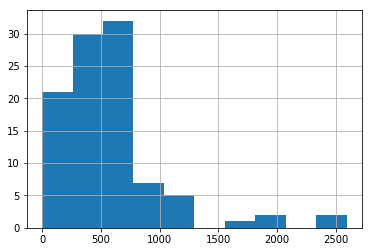

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.225117	valid's rmse: 0.226833
[200]	train's rmse: 0.22307	valid's rmse: 0.225379
[300]	train's rmse: 0.221763	valid's rmse: 0.224581
[400]	train's rmse: 0.220772	valid's rmse: 0.224109
[500]	train's rmse: 0.219908	valid's rmse: 0.223737
[600]	train's rmse: 0.219154	valid's rmse: 0.223517
[700]	train's rmse: 0.218456	valid's rmse: 0.223306
[800]	train's rmse: 0.217809	valid's rmse: 0.223182
[900]	train's rmse: 0.217182	valid's rmse: 0.223084
[1000]	train's rmse: 0.216607	valid's rmse: 0.222983
[1100]	train's rmse: 0.216033	valid's rmse: 0.2229
[1200]	train's rmse: 0.215464	valid's rmse: 0.222821
[1300]	train's rmse: 0.214935	valid's rmse: 0.222757
[1400]	train's rmse: 0.214398	valid's rmse: 0.222724
[1500]	train's rmse: 0.213886	valid's rmse: 0.222687
[1600]	train's rmse: 0.213369	valid's rmse: 0.222664
[1700]	train's rmse: 0.212883	valid's rmse: 0.222639
[1800]	train's rmse: 0.212403	valid's rmse: 0.22

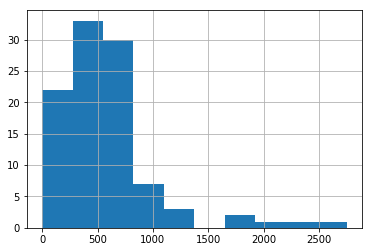

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.225538	valid's rmse: 0.225401
[200]	train's rmse: 0.223432	valid's rmse: 0.223915
[300]	train's rmse: 0.22214	valid's rmse: 0.223213
[400]	train's rmse: 0.221091	valid's rmse: 0.222712
[500]	train's rmse: 0.220238	valid's rmse: 0.222399
[600]	train's rmse: 0.219466	valid's rmse: 0.22216
[700]	train's rmse: 0.218746	valid's rmse: 0.221947
[800]	train's rmse: 0.218094	valid's rmse: 0.221806
[900]	train's rmse: 0.21747	valid's rmse: 0.221697
[1000]	train's rmse: 0.216886	valid's rmse: 0.221624
[1100]	train's rmse: 0.216321	valid's rmse: 0.22154
[1200]	train's rmse: 0.215751	valid's rmse: 0.221473
[1300]	train's rmse: 0.215221	valid's rmse: 0.221429
[1400]	train's rmse: 0.2147	valid's rmse: 0.221397
[1500]	train's rmse: 0.214189	valid's rmse: 0.221356
[1600]	train's rmse: 0.213699	valid's rmse: 0.221337
[1700]	train's rmse: 0.213201	valid's rmse: 0.221305
[1800]	train's rmse: 0.212721	valid's rmse: 0.22130

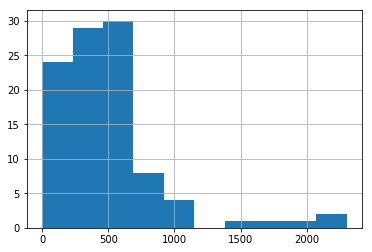

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.225448	valid's rmse: 0.225759
[200]	train's rmse: 0.223405	valid's rmse: 0.224284
[300]	train's rmse: 0.22209	valid's rmse: 0.223488
[400]	train's rmse: 0.221088	valid's rmse: 0.223022
[500]	train's rmse: 0.220246	valid's rmse: 0.222675
[600]	train's rmse: 0.219486	valid's rmse: 0.222435
[700]	train's rmse: 0.218772	valid's rmse: 0.222228
[800]	train's rmse: 0.218104	valid's rmse: 0.222069
[900]	train's rmse: 0.217487	valid's rmse: 0.221964
[1000]	train's rmse: 0.216914	valid's rmse: 0.221886
[1100]	train's rmse: 0.216355	valid's rmse: 0.221817
[1200]	train's rmse: 0.21581	valid's rmse: 0.221764
[1300]	train's rmse: 0.215284	valid's rmse: 0.22173
[1400]	train's rmse: 0.214748	valid's rmse: 0.221687
[1500]	train's rmse: 0.214236	valid's rmse: 0.22165
[1600]	train's rmse: 0.213755	valid's rmse: 0.221616
[1700]	train's rmse: 0.213258	valid's rmse: 0.22158
[1800]	train's rmse: 0.212767	valid's rmse: 0.2215

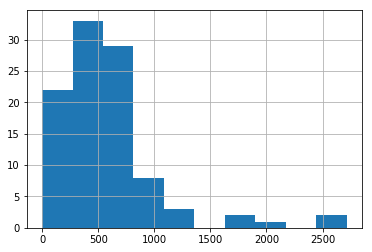

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.225251	valid's rmse: 0.226459
[200]	train's rmse: 0.223205	valid's rmse: 0.224938
[300]	train's rmse: 0.221888	valid's rmse: 0.224109
[400]	train's rmse: 0.22089	valid's rmse: 0.22363
[500]	train's rmse: 0.220038	valid's rmse: 0.223302
[600]	train's rmse: 0.21929	valid's rmse: 0.223063
[700]	train's rmse: 0.21855	valid's rmse: 0.222847
[800]	train's rmse: 0.217897	valid's rmse: 0.22272
[900]	train's rmse: 0.217274	valid's rmse: 0.222611
[1000]	train's rmse: 0.216683	valid's rmse: 0.222521
[1100]	train's rmse: 0.21611	valid's rmse: 0.222458
[1200]	train's rmse: 0.215557	valid's rmse: 0.222408
[1300]	train's rmse: 0.215028	valid's rmse: 0.222358
[1400]	train's rmse: 0.21451	valid's rmse: 0.222334
[1500]	train's rmse: 0.213995	valid's rmse: 0.222291
[1600]	train's rmse: 0.213494	valid's rmse: 0.222265
[1700]	train's rmse: 0.212996	valid's rmse: 0.22224
[1800]	train's rmse: 0.212513	valid's rmse: 0.222224


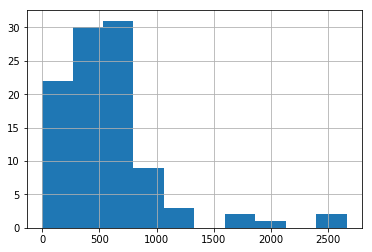

threshold= 481.2
Original dense features # = 100
Removed feature # = 10
Removed features:
 ['cityxcatxusertypeuser_type_fm_factor_1'
 'cityxcatxusertypeuser_type_fm_bias'
 'imgxisqnxusertypeuser_type_fm_factor_0'
 'imgxisqnxusertypeuser_type_fm_factor_1'
 'imgxisqnxusertypeuser_type_fm_bias' 'width' 'nasnet_nimamean'
 'user_type_cnt' 'weekday_cnt' 'user_type_dp_std_enc']
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.225358	valid's rmse: 0.225995
[200]	train's rmse: 0.22334	valid's rmse: 0.224559
[300]	train's rmse: 0.221999	valid's rmse: 0.223765
[400]	train's rmse: 0.220962	valid's rmse: 0.223287
[500]	train's rmse: 0.220077	valid's rmse: 0.222961
[600]	train's rmse: 0.219345	valid's rmse: 0.222741
[700]	train's rmse: 0.218609	valid's rmse: 0.222533
[800]	train's rmse: 0.217939	valid's rmse: 0.222385
[900]	train's rmse: 0.21733	valid's rmse: 0.2223
[1000]	train's rmse: 0.216735	valid's rmse: 0.222212
[1100]	train's rmse: 0.216175	valid's rmse: 0.

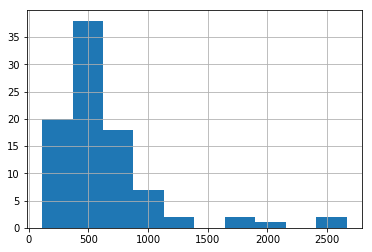

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.225221	valid's rmse: 0.226903
[200]	train's rmse: 0.223134	valid's rmse: 0.225368
[300]	train's rmse: 0.2218	valid's rmse: 0.224563
[400]	train's rmse: 0.220778	valid's rmse: 0.224037
[500]	train's rmse: 0.219928	valid's rmse: 0.223696
[600]	train's rmse: 0.219149	valid's rmse: 0.223452
[700]	train's rmse: 0.218422	valid's rmse: 0.22324
[800]	train's rmse: 0.217796	valid's rmse: 0.223106
[900]	train's rmse: 0.217185	valid's rmse: 0.223002
[1000]	train's rmse: 0.216592	valid's rmse: 0.222894
[1100]	train's rmse: 0.216024	valid's rmse: 0.222806
[1200]	train's rmse: 0.215493	valid's rmse: 0.222743
[1300]	train's rmse: 0.21497	valid's rmse: 0.222691
[1400]	train's rmse: 0.214443	valid's rmse: 0.222654
[1500]	train's rmse: 0.213929	valid's rmse: 0.222603
[1600]	train's rmse: 0.213424	valid's rmse: 0.222571
[1700]	train's rmse: 0.212936	valid's rmse: 0.222518
[1800]	train's rmse: 0.212461	valid's rmse: 0.222

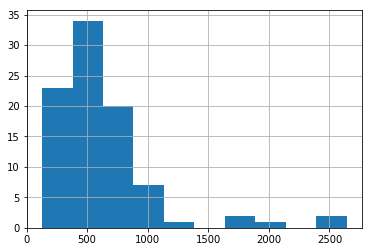

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.225524	valid's rmse: 0.225345
[200]	train's rmse: 0.223466	valid's rmse: 0.22387
[300]	train's rmse: 0.222126	valid's rmse: 0.223122
[400]	train's rmse: 0.221112	valid's rmse: 0.222669
[500]	train's rmse: 0.220232	valid's rmse: 0.222332
[600]	train's rmse: 0.21946	valid's rmse: 0.222099
[700]	train's rmse: 0.218737	valid's rmse: 0.22191
[800]	train's rmse: 0.218063	valid's rmse: 0.221756
[900]	train's rmse: 0.217468	valid's rmse: 0.221648
[1000]	train's rmse: 0.216891	valid's rmse: 0.221584
[1100]	train's rmse: 0.216326	valid's rmse: 0.221511
[1200]	train's rmse: 0.215776	valid's rmse: 0.221452
[1300]	train's rmse: 0.215246	valid's rmse: 0.221398
[1400]	train's rmse: 0.21471	valid's rmse: 0.221351
[1500]	train's rmse: 0.214216	valid's rmse: 0.221299
[1600]	train's rmse: 0.213743	valid's rmse: 0.221275
[1700]	train's rmse: 0.213257	valid's rmse: 0.221238
[1800]	train's rmse: 0.212792	valid's rmse: 0.221

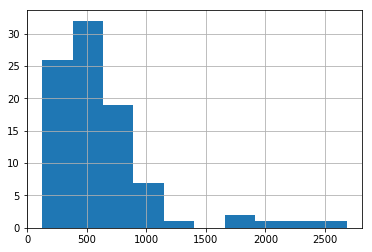

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.225494	valid's rmse: 0.225741
[200]	train's rmse: 0.223395	valid's rmse: 0.224226
[300]	train's rmse: 0.222069	valid's rmse: 0.223452
[400]	train's rmse: 0.221099	valid's rmse: 0.222986
[500]	train's rmse: 0.220261	valid's rmse: 0.222637
[600]	train's rmse: 0.219469	valid's rmse: 0.222373
[700]	train's rmse: 0.21877	valid's rmse: 0.22217
[800]	train's rmse: 0.218104	valid's rmse: 0.222008
[900]	train's rmse: 0.217487	valid's rmse: 0.221895
[1000]	train's rmse: 0.216917	valid's rmse: 0.221822
[1100]	train's rmse: 0.216365	valid's rmse: 0.22174
[1200]	train's rmse: 0.215809	valid's rmse: 0.221681
[1300]	train's rmse: 0.215263	valid's rmse: 0.221621
[1400]	train's rmse: 0.214738	valid's rmse: 0.221601
[1500]	train's rmse: 0.214232	valid's rmse: 0.221574
[1600]	train's rmse: 0.213747	valid's rmse: 0.221544
[1700]	train's rmse: 0.213253	valid's rmse: 0.221514
[1800]	train's rmse: 0.212766	valid's rmse: 0.22

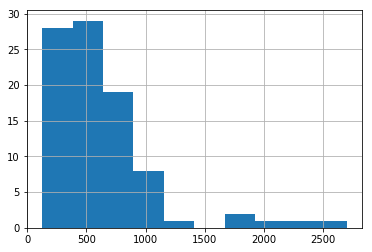

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.225315	valid's rmse: 0.226548
[200]	train's rmse: 0.22329	valid's rmse: 0.225041
[300]	train's rmse: 0.22198	valid's rmse: 0.224248
[400]	train's rmse: 0.220912	valid's rmse: 0.223695
[500]	train's rmse: 0.220053	valid's rmse: 0.223342
[600]	train's rmse: 0.219292	valid's rmse: 0.223096
[700]	train's rmse: 0.218547	valid's rmse: 0.22287
[800]	train's rmse: 0.21789	valid's rmse: 0.222723
[900]	train's rmse: 0.217283	valid's rmse: 0.222615
[1000]	train's rmse: 0.216695	valid's rmse: 0.222492
[1100]	train's rmse: 0.216099	valid's rmse: 0.222429
[1200]	train's rmse: 0.215568	valid's rmse: 0.222356
[1300]	train's rmse: 0.215039	valid's rmse: 0.222312
[1400]	train's rmse: 0.214511	valid's rmse: 0.22227
[1500]	train's rmse: 0.213992	valid's rmse: 0.222233
[1600]	train's rmse: 0.213502	valid's rmse: 0.22221
[1700]	train's rmse: 0.213014	valid's rmse: 0.222176
[1800]	train's rmse: 0.21254	valid's rmse: 0.22215


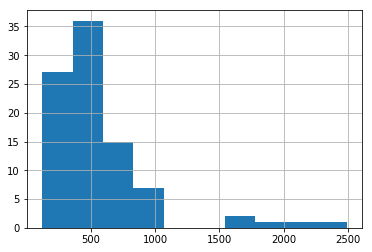

threshold= 1223.2
Original dense features # = 90
Removed feature # = 9
Removed features:
 ['num_words_title' 'cityxcatxusertypeuser_type_fm_factor_0'
 'nasnet_nimamax_non_max_mean_diff' 'city_cnt' 'category_name_cnt'
 'parent_category_name_cnt' 'isqn_binned_cnt' 'user_type_dp_mean_enc'
 'weekday_dp_std_enc']


['num_desc_punct',
 'words_vs_unique_description',
 'num_unique_words_description',
 'num_unique_words_title',
 'num_words_description',
 'avg_times_up_user',
 'avg_days_up_user',
 'n_user_items',
 'price',
 'item_seq_number',
 'cityxcatxusertypeitem_num',
 'cityxcatxusertypecity_fm_factor_0',
 'cityxcatxusertypecity_fm_factor_1',
 'cityxcatxusertypecategory_name_fm_factor_0',
 'cityxcatxusertypecategory_name_fm_factor_1',
 'cityxcatxusertypecity_fm_bias',
 'cityxcatxusertypecategory_name_fm_bias',
 'imgxcityxcatitem_num',
 'imgxcityxcatimage_top_1_fm_factor_0',
 'imgxcityxcatimage_top_1_fm_factor_1',
 'imgxcityxcatcity_fm_factor_0',
 'imgxcityxcatcity_fm_factor_1',
 'imgxcityxcatcategory_name_fm_factor_0',
 'imgxcityxcatcategory_name_fm_factor_1',
 'imgxcityxcatimage_top_1_fm_bias',
 'imgxcityxcatcity_fm_bias',
 'imgxcityxcatcategory_name_fm_bias',
 'imgxisqnxusertypeitem_num',
 'imgxisqnxusertypeimage_top_1_fm_factor_0',
 'imgxisqnxusertypeimage_top_1_fm_factor_1',
 'imgxisqnxusertyp

In [5]:
feature_select(2)
predictors

## Train OOF Models and Gen Submission

In [6]:
feature_names = np.hstack([
    count_vectorizer_desc.get_feature_names(),
    count_vectorizer_title.get_feature_names(),
    predictors
])
print('Number of features:', len(feature_names))

Number of features: 31528


In [7]:
from GridSearcher import data_loader, model_loader, fit_params, get_oof_predictions
ml = model_loader('lgb')

In [8]:
x_test = scipy.sparse.hstack([
    test_desc_counts,
    test_title_counts,
    test.loc[:, predictors].values
], format='csr')

In [9]:
x_train = scipy.sparse.hstack([
        train_desc_counts,
        train_title_counts,
        train.loc[:, predictors].values
    ], format='csr')

In [10]:
feature_names = np.hstack([
    count_vectorizer_desc.get_feature_names(),
    count_vectorizer_title.get_feature_names(),
    predictors
])
print('Number of features:', len(feature_names))

Number of features: 31528


In [11]:
rounds = 24000
early_stop_rounds = 200
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 270,
    'max_depth': -1,
    'learning_rate' : 0.02,
    'feature_fraction' : .6,
    'feature_fraction_seed': SEED,
    'bagging_fraction': .75,
    'bagging_freq': 4,
    'verbosity' : -1
}

ret = np.zeros((train.shape[0],))
ret_test = np.zeros((x_test.shape[0],))
ret_models = []
    
for train_ix, val_ix in kf.split(train):
    dtrain = lgb.Dataset(x_train[train_ix,:], label=y_train[train_ix],
                         feature_name=list(feature_names), 
                         categorical_feature=categorical)
    dvalid = lgb.Dataset(x_train[val_ix,:], label=y_train[val_ix],
                         feature_name=list(feature_names), 
                         categorical_feature=categorical)
    
    model = lgb.train(params, dtrain, 
                      valid_sets=[dtrain, dvalid], 
                      valid_names=['train', 'valid'],
                      num_boost_round=rounds, 
                      early_stopping_rounds=early_stop_rounds, 
                      verbose_eval=100)
    
    ret[val_ix] = model.predict(x_train[val_ix,:])
    ret_test += model.predict(x_test)
    ret_models.append(model)
    
    del dtrain, dvalid

C:\Users\khyeh\Anaconda3\lib\site-packages\lightgbm\basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.223626	valid's rmse: 0.225422
[200]	train's rmse: 0.218498	valid's rmse: 0.222171
[300]	train's rmse: 0.215295	valid's rmse: 0.220832
[400]	train's rmse: 0.212596	valid's rmse: 0.219925
[500]	train's rmse: 0.210246	valid's rmse: 0.219284
[600]	train's rmse: 0.208188	valid's rmse: 0.218836
[700]	train's rmse: 0.206359	valid's rmse: 0.218527
[800]	train's rmse: 0.204698	valid's rmse: 0.218313
[900]	train's rmse: 0.203169	valid's rmse: 0.218137
[1000]	train's rmse: 0.201685	valid's rmse: 0.217989
[1100]	train's rmse: 0.200258	valid's rmse: 0.217878
[1200]	train's rmse: 0.19893	valid's rmse: 0.21778
[1300]	train's rmse: 0.197614	valid's rmse: 0.21771
[1400]	train's rmse: 0.196367	valid's rmse: 0.217651
[1500]	train's rmse: 0.195142	valid's rmse: 0.217588
[1600]	train's rmse: 0.193945	valid's rmse: 0.217547
[1700]	train's rmse: 0.192781	valid's rmse: 0.217506
[1800]	train's rmse: 0.191632	valid's rmse: 0.21

KeyboardInterrupt: 

In [ ]:
'''
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.220653	valid's rmse: 0.225115
[200]	train's rmse: 0.213243	valid's rmse: 0.222044
[300]	train's rmse: 0.20899	valid's rmse: 0.221043
[400]	train's rmse: 0.206188	valid's rmse: 0.220538
'''

In [11]:
ret_test = ret_test / 5.

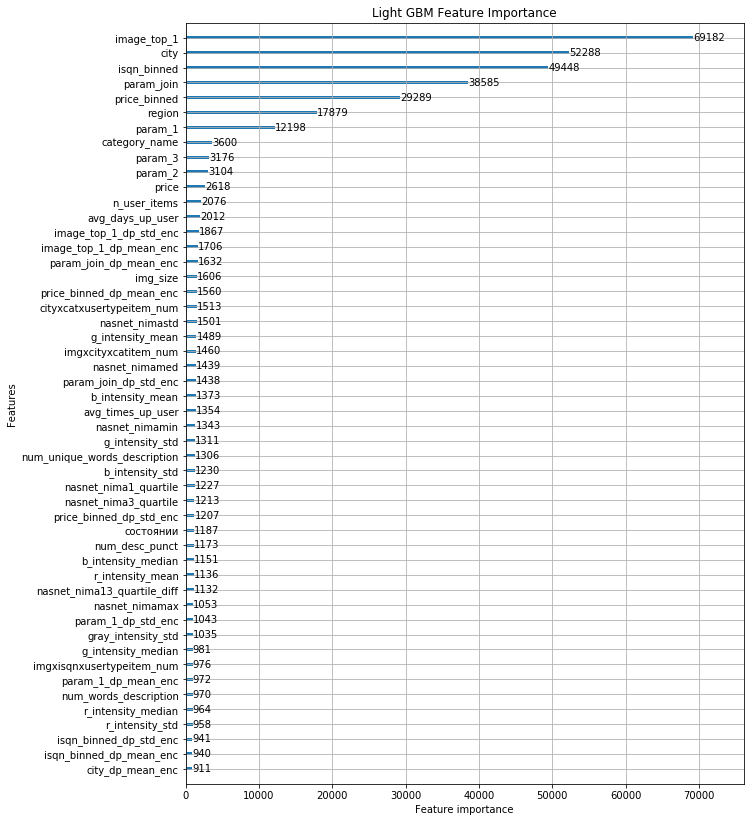

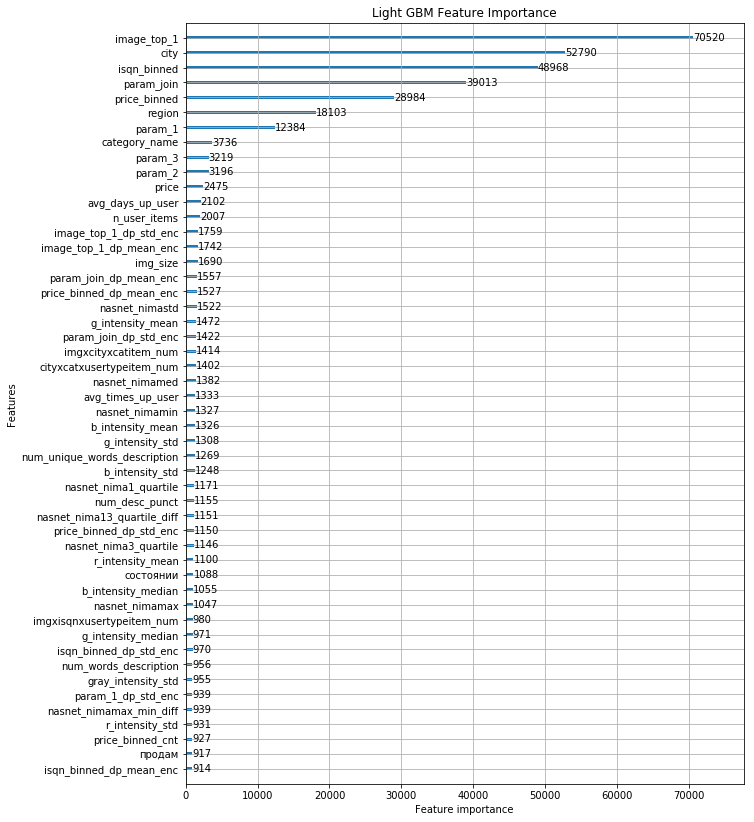

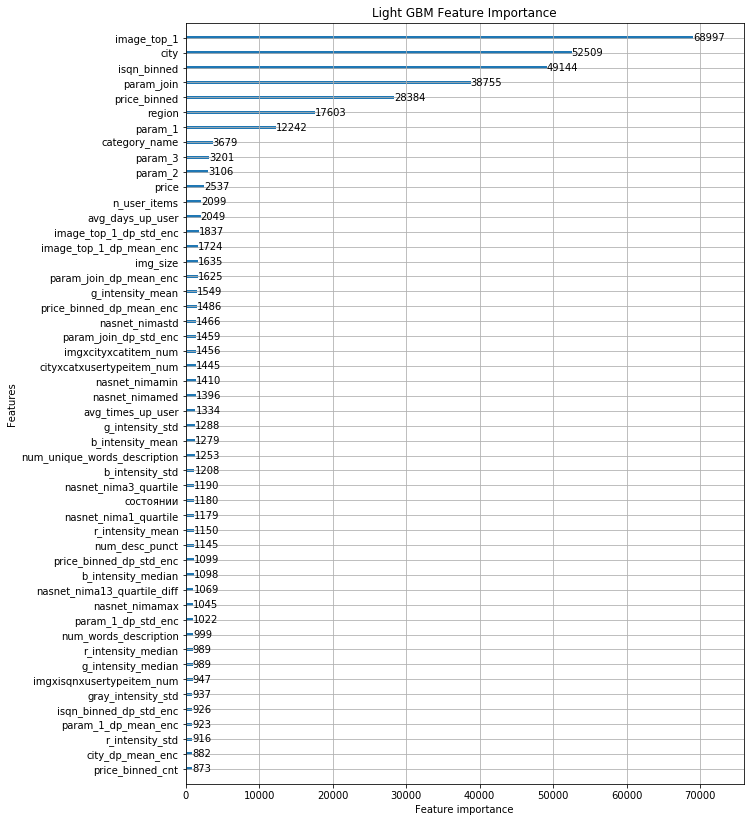

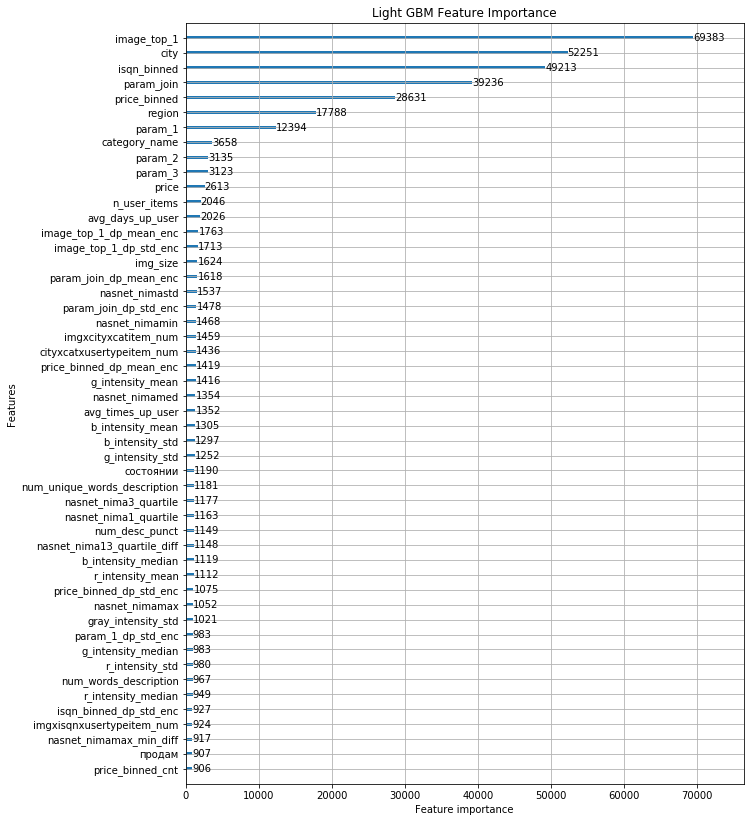

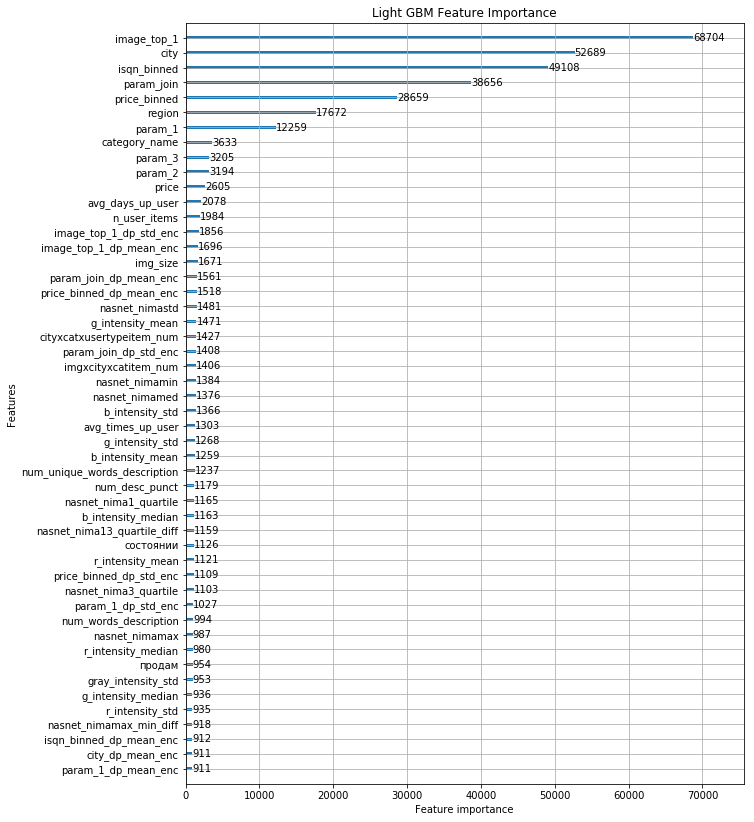

In [12]:
for model in ret_models:
    fig, ax = plt.subplots(figsize=(10, 14))
    lgb.plot_importance(model, max_num_features=50, ax=ax)
    plt.title("Light GBM Feature Importance")
    plt.show()

That looks good. But the model is kind of a black box. It is a good idea to plot the feature importances for our model now.

`avg_days_up`, `avg_times_up_user` and `n_user_items` are our most important engineered features! Looks like we were successful. Now we just have to predict the test matrix and submit!

In [13]:
pd.DataFrame(data=ret, columns=['img_meta_nima_fm_more_enc_lgb_pred']).to_csv('img_meta_nima_fm_more_enc_lgb_oof_val_pred.csv', index=False)
pd.DataFrame(data=ret_test, columns=['img_meta_nima_fm_more_enc_lgb_pred']).to_csv('img_meta_nima_fm_more_enc_lgb_oof_test_pred.csv', index=False)

In [14]:
subm = pd.read_csv('sample_submission.csv')
subm['deal_probability'] = np.clip(ret_test, 0, 1)
subm.to_csv('img_meta_nima_fm_more_enc_submission.csv', index=False)

In [15]:
import pickle
for md in ret_models:
    with open('models/img_meta_nima_fm_more_enc_lgb.model', 'wb') as handle:
        pickle.dump(md, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
ret_test

array([ 0.26945032,  0.14140974,  0.21073174, ...,  0.02104461,
        0.29128126,  0.05307897])

I'll end this kernel with some ideas to improve it:
- Use K-Fold cross validation.
- Try other methods than mean for reducing the aggregated features to one per user (e. g. modus or median).
- Try other gradient boosting libraries like CatBoost or XGBoost.
- Add a temporal dimension to engineered features (e. g. # of items a user put up for sale *per day*).
- Add more advanced text features like pretrained word embeddings.
- Add image features. At the moment we completely ignore images! (as discussed [here](https://www.kaggle.com/c/avito-demand-prediction/discussion/56678), two promising approaches could be [NIMA: Neural Image Assessment](https://arxiv.org/abs/1709.05424) and [Multimedia Features for Click Prediction](https://storage.googleapis.com/kaggle-forum-message-attachments/328059/9411/dimitri-clickadvert.pdf)).
- Normalize text before creating the Tf-Idf matrix (e. g. using [stemming](http://www.nltk.org/howto/stem.html)).
- ~~Learn russian and do in-depth text analysis.~~

Thanks for reading and have fun in this competition!